In [7]:
from ftplib import FTP
from io import BytesIO
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.interpolate import interp1d

c:\Users\ACER\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Function to download spectrum from FTP
def download_spectrum_ftp(url):
    from urllib.parse import urlparse

    parsed_url = urlparse(url)
    ftp_host = parsed_url.hostname
    ftp_file_path = parsed_url.path

    ftp = FTP(ftp_host)
    ftp.login()

    file_data = BytesIO()
    ftp.retrbinary(f"RETR {ftp_file_path}", file_data.write)
    ftp.quit()

    file_data.seek(0)
    return file_data.read()

# Intrinsic luminosity dictionary
intrinsic_lum = {
    'O5': 846000, 'O9': 95000,
    'B0': 20000, 'B1': 4600,
    'A0': 22, 'A2': 18,
    'F0': 4.3, 'F2': 3.3,
    'G0': 1.3, 'G2': 1,
    'K0': 0.54, 'K2': 0.38,
    'M0': 0.069, 'M1': 0.064
}

# Spectra URLs dictionary with explicit spectral type mapping
spectra_urls = {
    "O5": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko5v.fits",
    "O9": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko9v.fits",
    "B0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb0v.fits",
    "B1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb1v.fits",
    "A0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka0v.fits",
    "A2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka2v.fits",
    "F0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf0v.fits",
    "F2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf2v.fits",
    "G0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg0v.fits",
    "G2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg2v.fits",
    "K0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk0v.fits",
    "K2": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk2v.fits",
    "M0": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm0v.fits",
    "M1": "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm1v.fits"
}

# Download the spectra data
spectra = {key: download_spectrum_ftp(url) for key, url in spectra_urls.items()}

In [ ]:
# Masas para categorizar Estrellas
def Mclassifier(mass):
    if mass > 16:
        return "O"
    elif mass > 2.1:
        return "B"
    elif mass > 1.4:
        return "A"
    elif mass > 1.04:
        return "F"
    elif mass > 0.8:
        return "G"
    elif mass > 0.45:
        return "K"
    else:
        return "M"
    
# DISCRTEIZAR A 14 GYR, cambiar esto, como elegimos esta edad
universe_age = 14


def lum(mass):
    if mass > 55:
        return 3200 * mass
    elif mass > 2:
        return mass ** 4
    elif mass > 0.43:
        return 1.4 * mass ** 3.5
    else:
        return 0.23 * mass ** 2.3
 

def STARage(mass):
    #returns: time in SP, estimated age

    def SP_time(mass):
        sp_Sun = 10.0
        return sp_Sun / (mass ** 3)
    
    if mass > 5:
        return SP_time(mass), SP_time(mass)
    else: 
        return SP_time(mass) , SP_time(mass) + 1.1


spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

def read_spectrum_from_fits(data):
    with fits.open(BytesIO(data)) as hdul:
        spectrum_data = hdul[0].data
        header = hdul[0].header
        wavelengths = np.arange(header['CRVAL1'], header['CRVAL1'] + header['CDELT1'] * len(spectrum_data), header['CDELT1'])
        return wavelengths[:len(spectrum_data)], spectrum_data

# OCUPA LOS ESPECTROS REALES
def get_star_spectrum(spectral_type):
    if spectral_type in spectra:
        data = spectra[spectral_type][0]
        wavelengths, spectrum = read_spectrum_from_fits(data)
        return wavelengths, spectrum
    else:
        raise ValueError(f"Spectral type {spectral_type} not available in spectra.")
    

# Function to calculate the total luminosity of the spectrum
def tot_lum(wavelength, spectrum):
    luminosity = np.trapz(spectrum, x=wavelength)
    return luminosity


def normflux(wavelenght, spectrum):
    total_lum = tot_lum(wavelenght, spectrum)
    return spectrum / total_lum



    

In [ ]:
# el weight me lo da la imf
class STAR:
    def __init__(self, M, W, t):
        self.mass = M
        self.Tbirth = t
        self.weight = W # weight in relation of how many stars of this type are made
        self.lum = lum(M)
        self.Mtype = Mclassifier(M)
        self.SPtime = STARage(M)[0]
        self.wavelenght = get_star_spectrum(self.Mtype)[0]
        self.spectrum = get_star_spectrum(self.Mtype)[1]
        self.flux = normflux(self.wavelenght, self.spectrum)

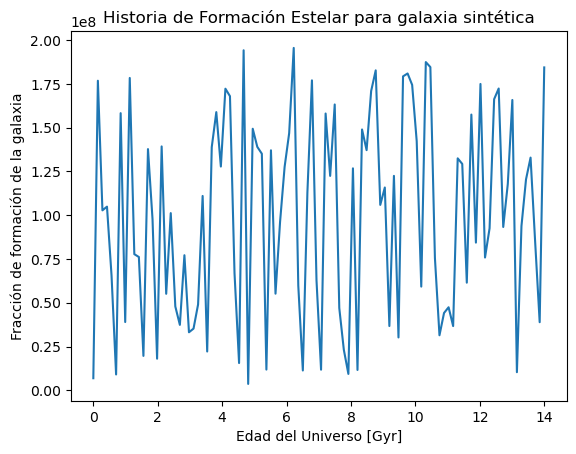

In [61]:
# formación estelar tipo random! no deberia ser asi pero por lo menos es algo.
def sfh(tuni,epochs,mass):
    #
    tstamps = np.linspace(0,tuni,epochs)
    sfr = np.array([random.uniform(0,1) for t in tstamps])
    norm_sfr = sfr/sum(sfr)
    return tstamps, norm_sfr*mass

a = sfh(14,100,1e10)


plt.plot(a[0], a[1])
plt.title("Historia de Formación Estelar para galaxia sintética")
plt.xlabel("Edad del Universo [Gyr]")
plt.ylabel("Fracción de formación de la galaxia")
plt.show()


hacer con get url

In [109]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

class IMF_salpeter:
    default_mmin = 0.3
    default_mmax = 120

    def __init__(self, alpha=2.35, mmin=None, mmax=None):
  
        self._mmin = self.default_mmin if mmin is None else mmin
        self._mmax = self.default_mmax if mmax is None else mmax
        self.alpha = alpha
        self.slope = -alpha

        assert self._mmin < self._mmax, "Minimum mass must be less than maximum mass."
        assert self._mmin > 0, "Minimum mass must be greater than zero."
        assert self._mmin != -1, "Minimum mass cannot be -1."

    def pdf(self, x):

        is_in_range = (x >= self._mmin) & (x <= self._mmax)
        return x**self.slope * is_in_range

    def __call__(self, m):

        integral, _ = scipy.integrate.quad(self.pdf, self._mmin, self._mmax)
        return self.pdf(m) / integral

    def generate_masses(self, min_mass, max_mass, e=1):
        #salpeter
        cte = 1.35
        return ((min_mass**-cte) - (max_mass ** -cte)) * (e / cte)

    def generate_mass_range(self, delta):
        return np.arange(self._mmin, self._mmax + delta, delta)

    def imf_fraction(self, mass_list, e=1):

        tot = self.generate_masses(mass_list[0], mass_list[-1], e)
        frac = np.zeros_like(mass_list[:-1])
        n = len(mass_list) - 1

        for i in range(n):
            frac[i] = self.generate_masses(mass_list[i], mass_list[i + 1], e)

        return frac / tot

    def generate_imf(self, delta, e=1):

        mass_range = self.generate_mass_range(delta)
        fractions = self.imf_fraction(mass_range, e)
        return mass_range, fractions



In [ ]:
#como agregar la IMF -> tiene una funcion generate masses que me sirve
class GALAXY:
    def __init__(self, M, min, max):
        self.stars = []
        self.minMass = min
        self.maxMAss = max
        self.tot_mass = M
        self.imf = IMF_salpeter()
    
    def Star_Formation(self, t, delta):
        mlist, fractions = self.imf.generate_imf(delta)
        for i in range(len(list)):
            self.stars.append(STAR(mlist[i],fractions[i],t))

        
        




SFH random, 10 secciones, importante, cada SFH va a tener distintas poblaciones, la idea es que todas las poblaciones evolucionen al mismo timepo, entregarle el timepo la fraccion: 

la fraccion que corresponde a la cantidad de gas, como estas utilizanod el gas para la galaxia, mulmass*fraccion de gas. 
Espectros y SFH,
lo unico que intersa de la SFH es la edad. 
medir edad al final de universo, ahora, decir que estamos midiendo gLAXIas cercanas, son galaxias cercanas.
datos generados sean lo mas uniforme posible en edades.

cuantos datos de galaxia? no más allá de 10.000 
entre 0 y 05 

30 min todos los datos,

test: Crear una unica poblacion y evolucionarla
darle tiempo en que nacio.
ver el espectro, despues de 
por conveniencia elegir 0. en t y vemos que pasa con el espectro. 




# PRUEBAS RANDOM MALAS ABAJO

In [139]:
import math

def calcsfr(mg):
    # Simple Schmidt-Kennicutt law, from Kennicutt (1998)
    # Here, mg is the gas surface density (in Msun pc^-2)
    logMg = math.log10(mg)
    logSFR = logMg * 1.4 - 3.5
    SFR = 1e-6 * 10**logSFR
    return SFR

# Example gas surface density
mg = 100000  # Msun pc^-2
sfr = calcsfr(mg)
print(f'Star Formation Rate: {sfr} Msun yr^-1')


Star Formation Rate: 0.0031622776601683794 Msun yr^-1


In [53]:
# Generar una SFH simple


# Integrar la SFH para obtener el SFR en diferentes épocas
def generate_sfh(times, tau=3):
    def simple_sfh(time, tau=5):
        return np.exp(-time / tau)
    sfr = simple_sfh(times, tau)
    return sfr

# Ejemplo de uso
n_stars = 1000
# initial_masses = generate_initial_masses(n_stars)
times = np.linspace(0, 14, 20)  # 14 Gyr
sfh = generate_sfh(times)

# Interpolación para obtener la SFR en cualquier tiempo
sfh_interp = interp1d(times, sfh, kind='cubic')

sfh

array([1.        , 0.78222408, 0.61187451, 0.47862297, 0.37439041,
       0.2928572 , 0.22907995, 0.17919185, 0.14016818, 0.10964293,
       0.08576534, 0.06708771, 0.05247762, 0.04104926, 0.03210972,
       0.025117  , 0.01964712, 0.01536845, 0.01202157, 0.00940356])

Mass Range: [  0.3   0.4   0.5 ... 119.8 119.9 120. ]
Fractions: [3.21938017e-01 1.76445597e-01 1.09510995e-01 ... 3.47242967e-07
 3.46562482e-07 3.45883896e-07]


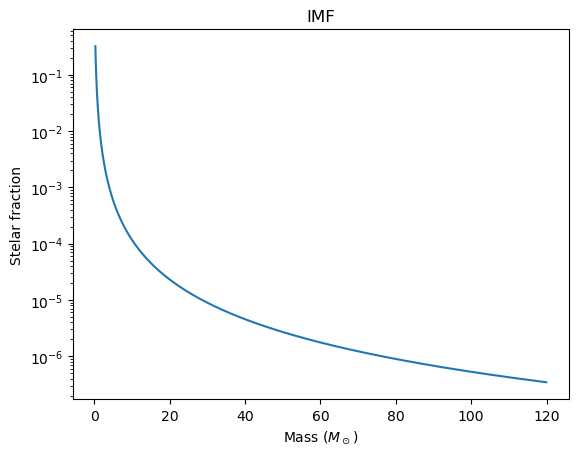

In [115]:
# Example usage
imf = IMF_salpeter()
delta = 0.1
mass_range, fractions = imf.generate_imf(delta)

print("Mass Range:", mass_range)
print("Fractions:", fractions)

# Plot the IMF
plt.plot(mass_range[:-1], fractions)
plt.yscale('log')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Stelar fraction')
plt.title('IMF')
plt.show()

Mass Range: [  0.3   0.4   0.5 ... 119.8 119.9 120. ]
Fractions: [3.21938017e-01 1.76445597e-01 1.09510995e-01 ... 3.47242967e-07
 3.46562482e-07 3.45883896e-07]


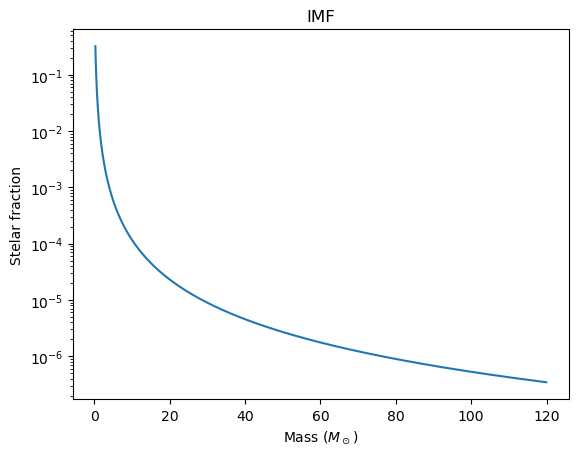

In [131]:
# Example usage
imf = IMF_salpeter()
delta = 0.1
mass_range, fractions = imf.generate_imf(delta)

print("Mass Range:", mass_range)
print("Fractions:", fractions)

# Plot the IMF
plt.plot(mass_range[:-1], fractions)
plt.yscale('log')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Stelar fraction')
plt.title('IMF')
plt.show()

In [133]:
len(mass_range)

1198

In [112]:
print("Mass Range:", mass_range)
print("Fractions:", fractions)
sum(fractions)

Mass Range: [  0.3   0.4   0.5 ... 119.8 119.9 120. ]
Fractions: [3.21938017e-01 1.76445597e-01 1.09510995e-01 ... 3.47242967e-07
 3.46562482e-07 3.45883896e-07]


1.0000000000000002

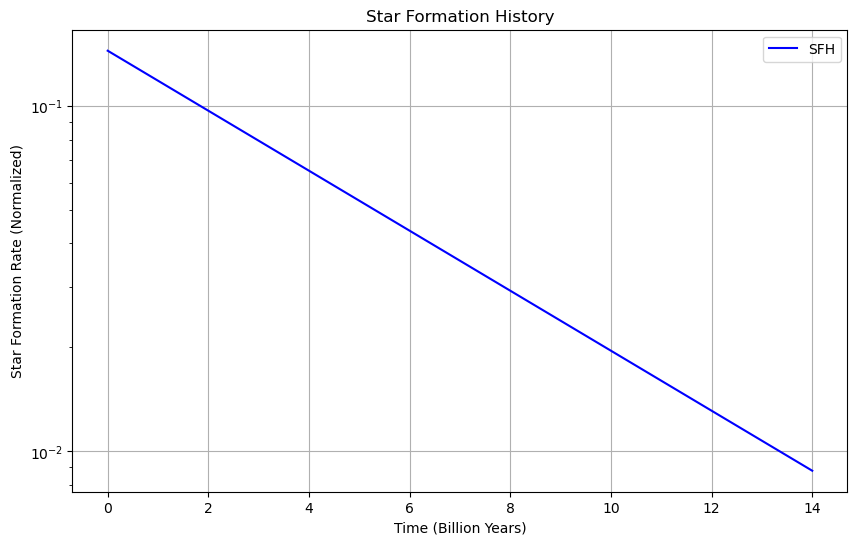

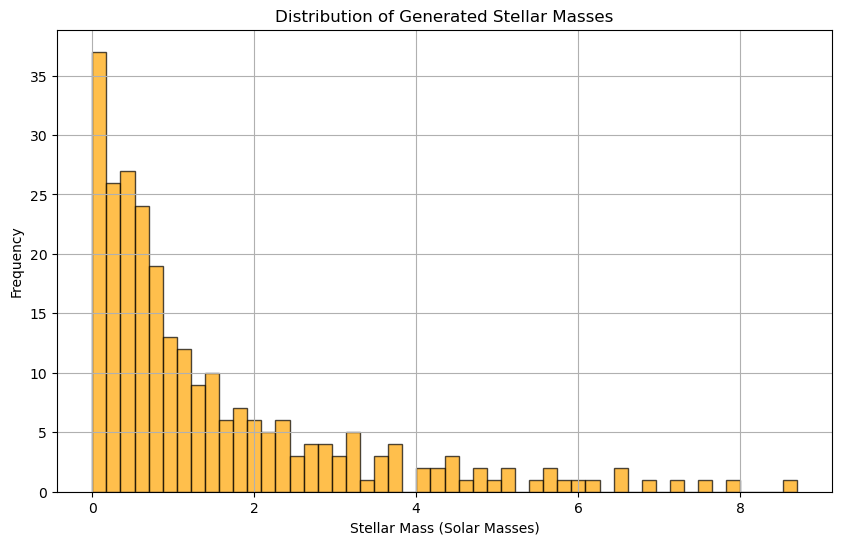

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate

class IMF_salpeter:
    default_mmin = 0.3
    default_mmax = 120

    def __init__(self, alpha=2.35, mmin=None, mmax=None):
        self._mmin = self.default_mmin if mmin is None else mmin
        self._mmax = self.default_mmax if mmax is None else mmax
        self.alpha = alpha
        self.slope = -alpha

        if not (0 < self._mmin < self._mmax):
            raise ValueError("mmin must be greater than 0 and less than mmax")
        if self._mmin == -1:
            raise ValueError("mmin cannot be -1")

        self.normalization_factor = self.calculate_normalization_factor()

    def calculate_normalization_factor(self):
        integral, _ = scipy.integrate.quad(self.raw_pdf, self._mmin, self._mmax)
        return 1.0 / integral

    def raw_pdf(self, x):
        return x ** self.slope

    def pdf(self, x):
        in_range = (x >= self._mmin) & (x <= self._mmax)
        return np.where(in_range, self.normalization_factor * x**self.slope, 0)

    def generate_masses(self, delta, sfr):
        mass_range = np.arange(self._mmin, self._mmax + delta, delta)
        masses = mass_range * sfr
        return masses

    def __call__(self, m):
        return self.pdf(m)

# Function to generate the SFH based on an exponential decline model
def generate_sfh(times, tau=5):
    def simple_sfh(time, tau):
        return np.exp(-time / tau)
    sfr = simple_sfh(times, tau)
    return sfr

# Example usage
n_stars = 10
times = np.linspace(0, 14, 20)  # 14 Gyr

# Generate the SFH
tau_sfh = 5  # Characteristic time scale in billions of years
sfh = generate_sfh(times, tau=tau_sfh)

# Normalize the SFH
sfh = sfh / np.sum(sfh)

# Plot the SFH
plt.figure(figsize=(10, 6))
plt.plot(times, sfh, label='SFH', color='blue')
plt.xlabel('Time (Billion Years)')
plt.ylabel('Star Formation Rate (Normalized)')
plt.title('Star Formation History')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

# Interpolation to obtain the SFR at any given time
sfh_interp = interp1d(times, sfh, kind='cubic')
#ESTO AUN ESTA MEDIO MALO!

# Generate SFRs using the interpolated SFH (assuming a total SFR of 1 solar mass per year)
total_sfr = 0.5  # Total star formation rate in solar masses per year
sfr = sfh_interp(times) * total_sfr

# # Plot the interpolated SFR
# plt.figure(figsize=(10, 6))
# plt.plot(times, sfr, label='Interpolated SFR', color='green')
# plt.xlabel('Time (Billion Years)')
# plt.ylabel('Star Formation Rate (Solar Masses per Year)')
# plt.title('Star Formation Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# Generate stellar masses using the IMF
imf = IMF_salpeter(alpha=2.35)
delta_mass = 10 # Mass resolution
stellar_masses = []

# Generate masses for each time step in the interpolated SFR
for sfr_value in sfr:
    masses = imf.generate_masses(delta_mass, sfr_value)
    stellar_masses.extend(masses)

# Convert the list to a numpy array for analysis
stellar_masses = np.array(stellar_masses)

# Plot the histogram of generated stellar masses
plt.figure(figsize=(10, 6))
plt.hist(stellar_masses, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Frequency')
plt.title('Distribution of Generated Stellar Masses')
plt.grid(True)
plt.yscale
plt.show()


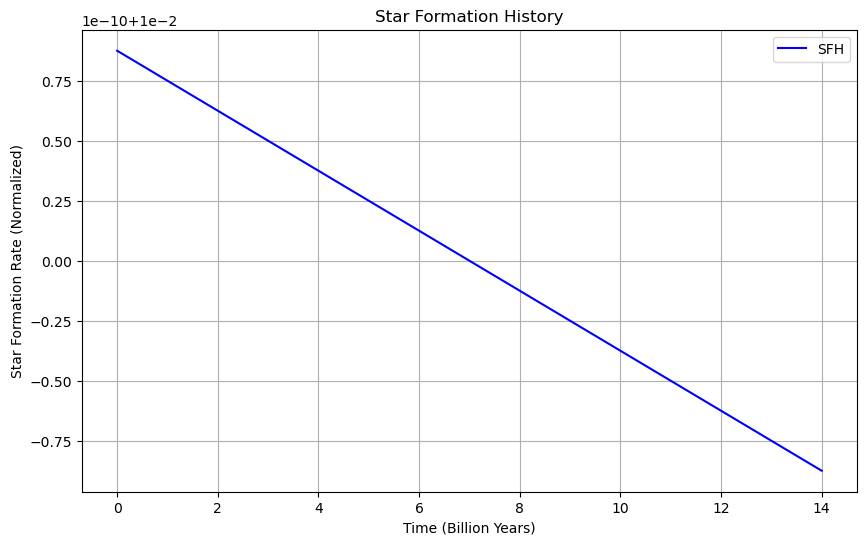

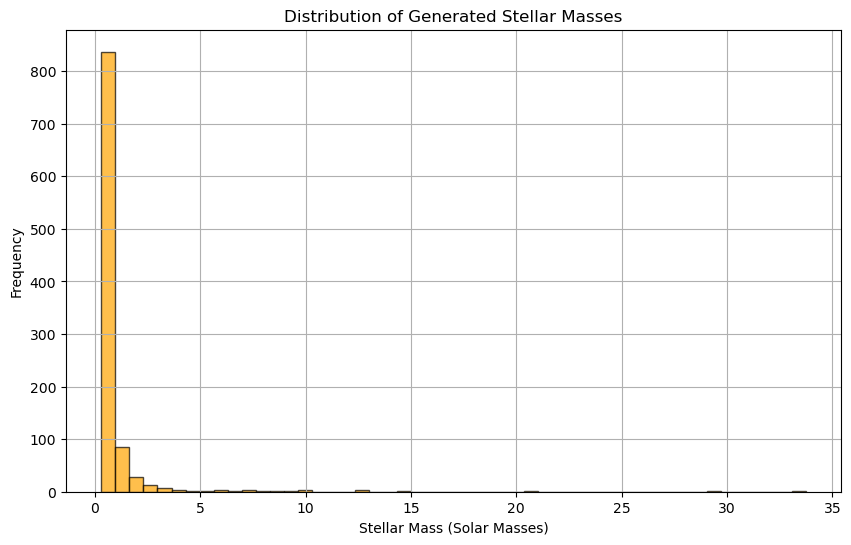

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate

class IMF_salpeter:
    default_mmin = 0.3
    default_mmax = 120

    def __init__(self, alpha=2.35, mmin=None, mmax=None):
        self._mmin = self.default_mmin if mmin is None else mmin
        self._mmax = self.default_mmax if mmax is None else mmax
        self.alpha = alpha
        self.slope = -alpha

        if not (0 < self._mmin < self._mmax):
            raise ValueError("mmin must be greater than 0 and less than mmax")
        if self._mmin == -1:
            raise ValueError("mmin cannot be -1")

        self.normalization_factor = self.calculate_normalization_factor()

    def calculate_normalization_factor(self):
        integral, _ = scipy.integrate.quad(self.raw_pdf, self._mmin, self._mmax)
        return 1.0 / integral

    def raw_pdf(self, x):
        return x ** self.slope

    def pdf(self, x):
        in_range = (x >= self._mmin) & (x <= self._mmax)
        return np.where(in_range, self.normalization_factor * x**self.slope, 0)

    def generate_masses(self, n_stars, sfr):
        cumulative_sfr = np.cumsum(sfr)
        cumulative_sfr /= cumulative_sfr[-1]  # Normalize 
        random_numbers = np.random.random(n_stars)
        time_bins = np.searchsorted(cumulative_sfr, random_numbers)
        masses = []

        for i in time_bins:
            mass_range = np.linspace(self._mmin, self._mmax, n_stars)
            prob_distribution = self.pdf(mass_range)
            prob_distribution /= np.sum(prob_distribution)  # Normalize
            selected_mass = np.random.choice(mass_range, p=prob_distribution)
            masses.append(selected_mass)

        return np.array(masses)

    def __call__(self, m):
        return self.pdf(m)

# Function to generate the SFH based on an exponential decline model
def generate_sfh(times, tau=5):
    def simple_sfh(time, tau):
        return np.exp(-time / tau)
    sfr = simple_sfh(times, tau)
    return sfr

# Example usage
n_stars = 1000
times = np.linspace(0, 14, 100)  # 14 Gyr

# Generate the SFH
tau_sfh = 8.e+8  # Characteristic time scale in billions of years
sfh = generate_sfh(times, tau=tau_sfh)

# Normalize the SFH
sfh = sfh / np.sum(sfh)

# Plot the SFH
plt.figure(figsize=(10, 6))
plt.plot(times, sfh, label='SFH', color='blue')
plt.xlabel('Time (Billion Years)')
plt.ylabel('Star Formation Rate (Normalized)')
plt.title('Star Formation History')
plt.legend()
plt.grid(True)
plt.show()

# Interpolation to obtain the SFR at any given time
sfh_interp = interp1d(times, sfh, kind='cubic')

# Define the total SFR using observational data
sfr = calcsfr(mg) # Example: Total star formation rate in solar masses per year
total_sfr = .10

# Generate SFRs using the interpolated SFH
sfr = sfh_interp(times) * total_sfr

# Plot the interpolated SFR
# plt.figure(figsize=(10, 6))
# plt.plot(times, sfr, label='Interpolated SFR', color='green')
# plt.xlabel('Time (Billion Years)')
# plt.ylabel('Star Formation Rate (Solar Masses per Year)')
# plt.title('Star Formation Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# Generate stellar masses using the IMF
imf = IMF_salpeter(alpha=2.35)
stellar_masses = imf.generate_masses(n_stars, sfr)

# Plot the histogram of generated stellar masses
plt.figure(figsize=(10, 6))
plt.hist(stellar_masses, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Frequency')
plt.title('Distribution of Generated Stellar Masses')
plt.grid(True)
plt.show()


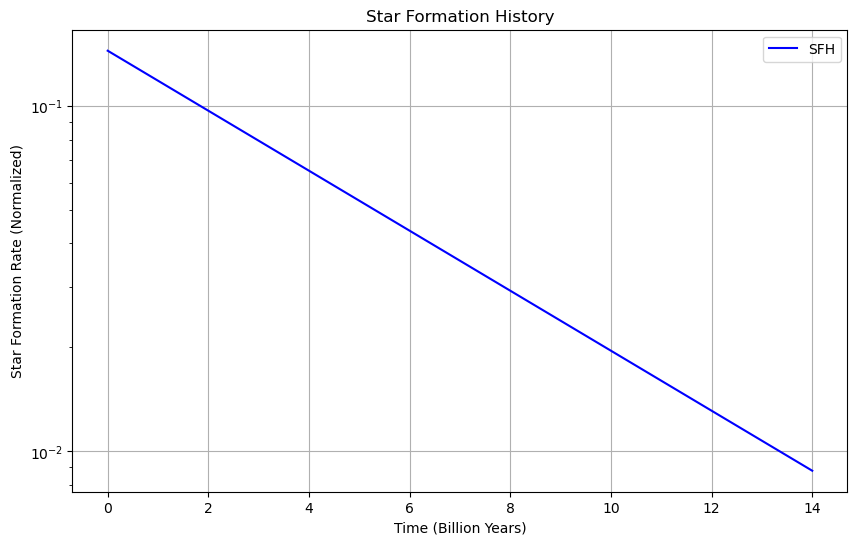

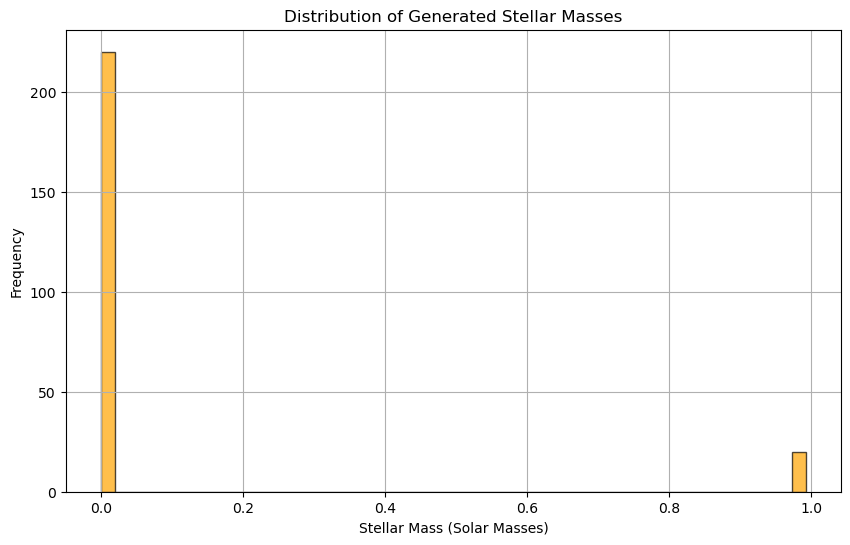

In [128]:
# Example usage
n_stars = 10
times = np.linspace(0, 14, 20)  # 14 Gyr

# Generate the SFH
tau_sfh = 5  # Characteristic time scale in billions of years
sfh = generate_sfh(times, tau=tau_sfh)

# Normalize the SFH
sfh = sfh / np.sum(sfh)

# Plot the SFH
plt.figure(figsize=(10, 6))
plt.plot(times, sfh, label='SFH', color='blue')
plt.xlabel('Time (Billion Years)')
plt.ylabel('Star Formation Rate (Normalized)')
plt.title('Star Formation History')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

# Interpolation to obtain the SFR at any given time
sfh_interp = interp1d(times, sfh, kind='cubic')
#ESTO AUN ESTA MEDIO MALO!

# Generate SFRs using the interpolated SFH (assuming a total SFR of 1 solar mass per year)
total_sfr = 0.5  # Total star formation rate in solar masses per year
sfr = sfh_interp(times) * total_sfr

# # Plot the interpolated SFR
# plt.figure(figsize=(10, 6))
# plt.plot(times, sfr, label='Interpolated SFR', color='green')
# plt.xlabel('Time (Billion Years)')
# plt.ylabel('Star Formation Rate (Solar Masses per Year)')
# plt.title('Star Formation Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# Generate stellar masses using the IMF
# imf = IMF_salpeter()
delta_mass = 10 # Mass resolution
stellar_masses = []

# Generate masses for each time step in the interpolated SFR
for sfr_value in sfr:
    stellar_masses.extend(fractions)

# Convert the list to a numpy array for analysis
stellar_masses = np.array(stellar_masses)

# Plot the histogram of generated stellar masses
plt.figure(figsize=(10, 6))
plt.hist(stellar_masses, bins=50, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Frequency')
plt.title('Distribution of Generated Stellar Masses')
plt.grid(True)
plt.yscale
plt.show()